<a href="https://colab.research.google.com/github/ykato27/Text-to-Image/blob/main/Text2Image_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">Text2Image</font></b>

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository**: [CLIP](https://github.com/openai/CLIP)

Article: [Learning Transferable Visual Models From Natural Language Supervision](https://cdn.openai.com/papers/Learning_Transferable_Visual_Models_From_Natural_Language_Supervision.pdf)

Creator: **[OpenAI](https://openai.com/)**

Colab based on **[Ryan Murdock's](https://rynmurdock.github.io/)** notebook.

<b><font color="black" size="+2">Colab created by:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@bomze](https://t.me/bomze),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).

---


```
(ENG) To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```


In [1]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Install all necessary libraries</font></b>

try: 
  !pip3 install googletrans==3.1.0a0
  from googletrans import Translator, constants
  from pprint import pprint
  translator = Translator()
except: pass

import subprocess
CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import os
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import glob
from google.colab import output

!git clone https://github.com/openai/CLIP.git
%cd /content/CLIP/
!pip install ftfy
import clip
import numpy as np
perceptor, preprocess = clip.load('ViT-B/32')

!mkdir frames
import moviepy.editor as mpy
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from google.colab import files
import warnings
from IPython.display import clear_output
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline
clear_output()
!nvidia-smi -L
print('\nDone!')

GPU 0: Tesla K80 (UUID: GPU-a32163f8-d025-f314-5f0b-54d930ed0e5f)

Done!


Picture number 51



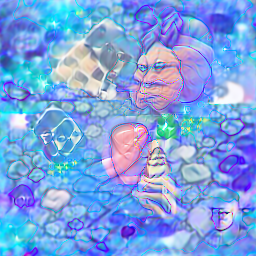


(ENG) Please wait a few seconds until the next picture
(RUS) Пожалуйста подождите несколько секунд, пока не появится новое изображение


KeyboardInterrupt: ignored

In [2]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Start Processing</font></b>

!rm -rf /content/CLIP/frames/*.*
#@markdown **(ENG)** Enter a description for the picture and click the "Play" button. Text can be written in any language.

text = 'Forbidden love' #@param {type:"string"}
try:
  translation = translator.translate(text)
  prompt = translation.text
except: prompt = text
#@markdown **(ENG) Attention!** This process is almost endless, so watch the results and stop this block when you think it's time. Press the "Play" button again to stop.

#@markdown ---
resolution = "256" #@param [128, 256, 512]
res = int(resolution)
im_shape = [res, res, 3]
sideX, sideY, channels = im_shape

tx = clip.tokenize(prompt)
frames_frequency = "high" #@param ['high', 'medium', 'low']
if frames_frequency=='low': fr = 150
elif frames_frequency=='medium': fr = 100
else: fr = 50
audio_notification = False #@param {type:"boolean"}

# Define some helper functions
def displ(img, pre_scaled=True):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  if not pre_scaled:
    img = scale(img, 48*4, 32*4)
  imageio.imwrite('result.png', np.array(img))
  file_path = '/content/CLIP/frames/{}.png'.format(str(len(os.listdir('/content/CLIP/frames'))).zfill(5))
  imageio.imwrite(file_path, np.array(img))
  return display.Image('result.png')

def card_padded(im, to_pad=3):
  return np.pad(np.pad(np.pad(im, [[1,1], [1,1], [0,0]],constant_values=0), [[2,2], [2,2], [0,0]],constant_values=1),
            [[to_pad,to_pad], [to_pad,to_pad], [0,0]],constant_values=0)

import torch.nn as nn

class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=True, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True)
        output = self.net(coords.cuda())
        return output.view(1, sideX, sideY, 3).permute(0, 3, 1, 2)#.sigmoid_()

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations


def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid


model = Siren(in_features=2, out_features=3, hidden_features=256, 
                  hidden_layers=16, outermost_linear=False)
model.cuda()
LLL = []
eps = 0
optimizer = torch.optim.Adam(model.parameters(), .00001)

def checkin(loss):
  #print(loss)
  with torch.no_grad():
    al = nom(model(get_mgrid(sideX)).cpu()).numpy()
  for allls in al:
    displ(allls)
    clear_output()
    pic_num = str(len(os.listdir('/content/CLIP/frames')))
    print(f'Picture number {pic_num}\n')
    if int(pic_num) == 1:
      print("\n(ENG) Don't be alarmed. The first image is always bad")
    display.display(display.Image('result.png'))
    print('\n(ENG) Please wait a few seconds until the next picture')
  if audio_notification == True: output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')


def ascend_txt():
  out = model(get_mgrid(sideX))

  cutn = 64
  p_s = []
  for ch in range(cutn):
    size = torch.randint(int(.5*sideX), int(.98*sideX), ())
    offsetx = torch.randint(0, sideX - size, ())
    offsety = torch.randint(0, sideX - size, ())
    apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='bilinear')
    p_s.append(nom(apper))
  into = torch.cat(p_s, 0)

  iii = perceptor.encode_image(into)
  t = perceptor.encode_text(tx.cuda())
  return -100*torch.cosine_similarity(t, iii, dim=-1).mean()

def train(epoch, i):
  loss = ascend_txt()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  if itt % fr == 0:
    checkin(loss)

nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

itt = 0
for epochs in range(10000):
  for i in range(1000):
    train(eps, i)
    itt+=1
  eps+=1

In [3]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generate Video</font></b>

#@markdown **(ENG) Attention!** The duration of the video will depend on how many pictures you generated in the previous block. 10 frames = 1 sec..

frames = []
img = os.listdir("/content/CLIP/frames")
img.sort()
for i in img:
  frames.append(imageio.imread("/content/CLIP/frames/"+i))
frames = np.array(frames)
imageio.mimsave('/content/CLIP/video.mp4', frames)
clear_output()

from IPython.display import HTML
import io
import base64
video = io.open('/content/CLIP/video.mp4', 'r+b').read()
encoded = base64.b64encode(video)
play_html = ('<video alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'.format(encoded.decode('ascii')))
HTML(data=play_html)

In [4]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Download results</font></b>
last_image = True #@param {type:"boolean"}
video = True #@param {type:"boolean"}
if last_image==True: files.download('/content/CLIP/result.png')
if video==True: files.download('/content/CLIP/video.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>